In [88]:
%matplotlib inline
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [3]:
events = pd.read_csv('event_data_train.csv')
submissions = pd.read_csv('submissions_data_train.csv')
events['date'] = pd.to_datetime(events.timestamp, unit='s').dt.date
submissions['date'] = pd.to_datetime(submissions.timestamp, unit='s').dt.date

In [4]:
events.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15


In [5]:
submissions.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15


In [6]:
events.shape, submissions.shape

((3480703, 5), (509104, 5))

In [7]:
events.user_id.nunique(), submissions.user_id.nunique() #as we can see, some users don't have any submissions

(19234, 9940)

(Text(0.5, 0, 'date'), Text(0, 0.5, 'number of actions'))

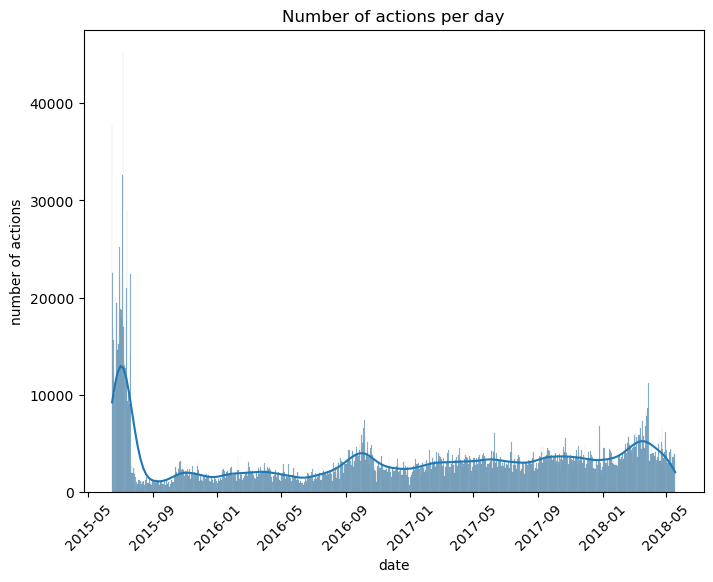

In [98]:
ev_date_hist = plt.figure(figsize=(8, 6))
sns.histplot(events['date'], kde=True)
plt.title('Number of actions per day')
plt.xticks(rotation='45')
plt.xlabel('date'), plt.ylabel('number of actions')

In [8]:
diff_between_steps = events[['timestamp', 'user_id', 'date']].drop_duplicates(subset=['date', 'user_id'])\
                                                             .groupby('user_id')['timestamp']\
                                                             .apply(list).apply(np.diff).values

In [9]:
#Transform difference between days timestamp in days
gap_data = pd.Series(np.concatenate(diff_between_steps))
gap_data = gap_data.apply(lambda ts: round(ts/(24*60*60)))

In [10]:
break_days_count = pd.DataFrame(gap_data.value_counts()).drop(0, axis=0)\
                                                        .rename({0: 'days_count'}, axis=1)\
                                                        .sort_values(by='days_count', ascending=False)
break_days_count = break_days_count.set_index(break_days_count.index.astype('int64'))                               
break_days_count.head()

,days_count
1,49362
2,11520
3,6488
4,3893
5,2827


Text(0, 0.5, 'count')

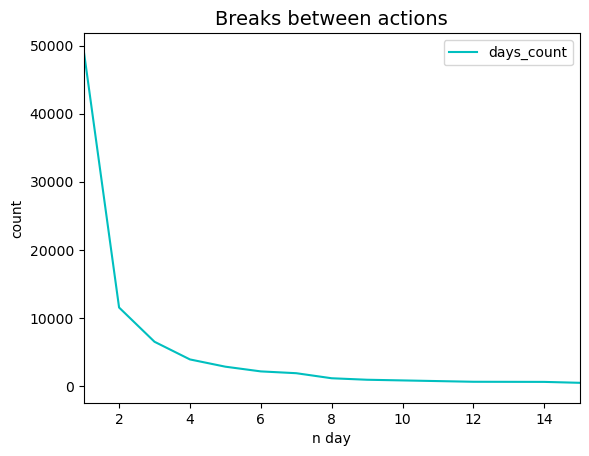

In [11]:
break_days_count.plot(c='c')
plt.title('Breaks between actions', fontdict={'fontsize': 14})
plt.xlabel('n day')
plt.xlim(1, 15)
plt.ylabel('count')
#the most frequent of days break is 1 and 2, so we will make our predictions by first 2 days 
#(and it also says in the task)

In [12]:
user_steps = pd.pivot_table(events, index='user_id',  columns='action', 
                            values  = 'step_id', aggfunc = 'count',
                            fill_value = 0).reset_index()
user_steps.sort_values(by='passed').tail()

action,user_id,discovered,passed,started_attempt,viewed
7025,9751,198,198,98,486
15993,22298,198,198,115,560
18743,26117,198,198,99,346
9026,12529,198,198,90,584
14164,19683,197,198,94,365


In [13]:
first_encounter = events[['timestamp', 'user_id']].groupby('user_id', as_index=False)\
                                                  .agg({'timestamp': 'min'})\
                                                  .rename({'timestamp': 'first_timestmap'}, axis=1)

In [14]:
events = events.merge(first_encounter, on='user_id')
events.head()

,step_id,timestamp,action,user_id,date,first_timestmap
0,32815,1434340848,viewed,17632,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15,1434340848


In [15]:
n_days = 2 #number of days for threshold
events_first_days = events[(events['timestamp'] < events['first_timestmap']+n_days*24*60*60)]

In [16]:
events_first_days.head()

,step_id,timestamp,action,user_id,date,first_timestmap
0,32815,1434340848,viewed,17632,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15,1434340848


In [17]:
events_table = events_first_days.pivot_table(index='user_id', columns='action',
                                             values='step_id', aggfunc='count',
                                             fill_value=0).sort_values('viewed', ascending=False).reset_index()
events_table.columns.names = ['']
events_table.head()

,user_id,discovered,passed,started_attempt,viewed
0,1046,7,8,23,568
1,9880,115,67,2,524
2,25279,124,83,0,473
3,2514,50,31,0,458
4,13678,136,114,116,397


In [18]:
submission_count_all = submissions[['user_id', 'submission_status']].groupby(['user_id', 'submission_status'], as_index=False)\
                                                                    .size().rename({'size': 'sub_count'}, axis=1)
passed_ids = submission_count_all[(submission_count_all.submission_status=='correct') & #count guys, who got more then 
                                  (submission_count_all.sub_count>40)].user_id          #40 correct answers, as passed

In [19]:
first_encounter = submissions[['timestamp', 'user_id']].groupby('user_id', as_index=False)\
                                                       .agg({'timestamp': 'min'})\
                                                       .rename({'timestamp': 'first_timestmap'}, axis=1)

In [20]:
submissions_first_days = submissions.merge(first_encounter, on='user_id')

In [21]:
submissions_first_days = submissions_first_days[(submissions_first_days['timestamp'] <
                                                 submissions_first_days['first_timestmap']+2*24*60*60)]

In [22]:
submissions_first_days.head()

,step_id,timestamp,submission_status,user_id,date,first_timestmap
0,31971,1434349275,correct,15853,2015-06-15,1434346056
1,31972,1434348300,correct,15853,2015-06-15,1434346056
4,31976,1434348123,wrong,15853,2015-06-15,1434346056
5,31976,1434348188,correct,15853,2015-06-15,1434346056
7,31977,1434347371,correct,15853,2015-06-15,1434346056


In [23]:
submission_count_fd = submissions_first_days[['user_id', 'submission_status']].groupby(['user_id', 'submission_status'], as_index=False)\
                                                                           .size().rename({'size': 'sub_count'}, axis=1)

In [24]:
submission_count_fd = submission_count_fd.pivot_table(index='user_id', columns='submission_status', values='sub_count')\
                                   .reset_index().fillna(0)
submission_count_fd.columns.names = ['']
submission_count_fd.head()

,user_id,correct,wrong
0,2,2.0,0.0
1,3,4.0,4.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


In [25]:
events_table = events_table.merge(submission_count_fd, on='user_id', how='left').fillna(0)

In [26]:
events_table['correct_ratio'] = round((events_table['correct'] / (events_table['correct'] + events_table['wrong'])), 2)
events_table = events_table.fillna(0)
events_table.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
0,1046,7,8,23,568,17.0,8.0,0.68
1,9880,115,67,2,524,0.0,0.0,0.00
2,25279,124,83,0,473,0.0,0.0,0.00
3,2514,50,31,0,458,0.0,0.0,0.00
4,13678,136,114,116,397,36.0,183.0,0.16


In [27]:
events_table['complete'] = (events_table.user_id.isin(passed_ids))
events_table['complete'].replace([True, False], [1, 0], inplace=True)
events_table.complete.value_counts()

0    17266
1     1968
Name: complete, dtype: int64

In [28]:
events_table.user_id.nunique() #checking if no data has been lost (should be 19234, as in 7 cell)

19234

In [29]:
#create df with new users (have entered our course less then one week ago) 
#and delete them from our resulting table, 
#because we don't have much info about to classify them
last_timestamp = events.timestamp.max()
new_users = events[['user_id', 'timestamp']].groupby('user_id', as_index=False)\
                                            .agg({'timestamp': 'min'})
new_users = new_users[new_users.timestamp > (last_timestamp - 7*24*60*60)].user_id
events_table = events_table[~events_table.user_id.isin(new_users)]

In [48]:
events_table.user_id.nunique(), new_users.count() #19234 - 184 = 19050 => all correct

(19050, 184)

Text(0.5, 1.0, 'Correlation Table')

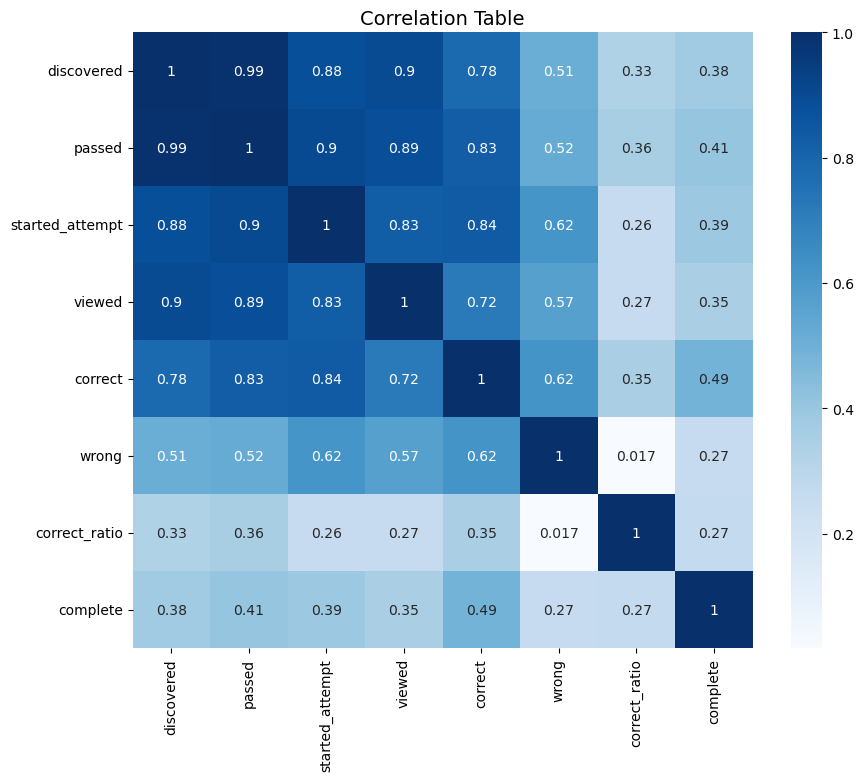

In [30]:
hm_fig = plt.figure(figsize=(10,8))
corr = events_table.drop('user_id', axis=1).corr()
sns.heatmap(corr, cmap="Blues", annot=True,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.title('Correlation Table', fontdict={'fontsize': 14})

In [31]:
#split our resulting table in two blocks: features and target
#and delete from our features those who are to much correlated with each other
X = events_table.drop(['user_id', 'complete', 'discovered', 'started_attempt', 'viewed'], axis=1) 
y = events_table.complete
X.head()

,passed,correct,wrong,correct_ratio
0,8,17.0,8.0,0.68
1,67,0.0,0.0,0.00
2,83,0.0,0.0,0.00
3,31,0.0,0.0,0.00
4,114,36.0,183.0,0.16


In [32]:
#now let's get best params for our classifier (Random Forest), using GridSearchCV
rf = RandomForestClassifier(random_state=123)
params = {'n_estimators': range(10, 30, 5), 'max_depth': range(2, 10),
          'min_samples_leaf': range(1, 5), 'min_samples_split': range(2, 10)}
grid_rf = GridSearchCV(rf, params, cv=3, n_jobs=-1)

In [33]:
grid_rf.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(10, 30, 5)})

In [34]:
best_rf = grid_rf.best_estimator_
best_rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=2, n_estimators=25, random_state=123)>

In [35]:
features_scores = best_rf.feature_importances_
features_scores

array([0.31962325, 0.49031626, 0.02475567, 0.16530482])

In [36]:
feat = pd.DataFrame({'feature': list(X), 'feature_importance': features_scores})

<AxesSubplot:ylabel='feature'>

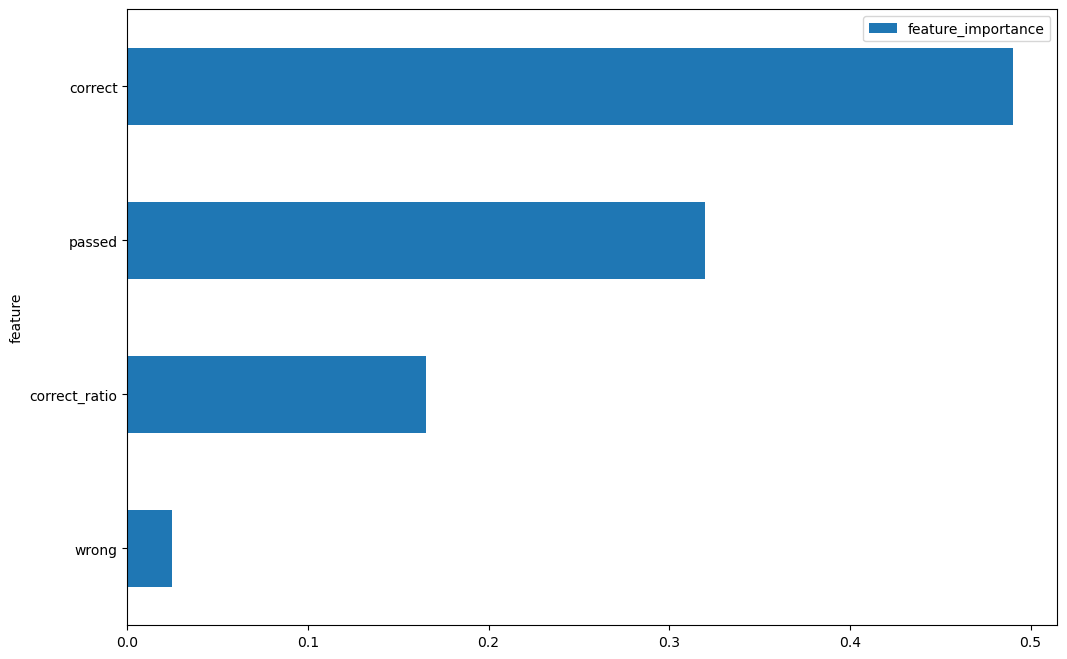

In [37]:
feat['feature_importance'] = feat['feature_importance'].round(4)
feat.sort_values(by='feature_importance', ascending=True)\
    .plot(y='feature_importance', x='feature', kind='barh', figsize=(12, 8))

In [38]:
sub_test = pd.read_csv('submission_data_test.csv')
events_test = pd.read_csv('events_data_test.csv')
events_test['date'] = pd.to_datetime(events_test.timestamp, unit='s').dt.date
sub_test['date'] = pd.to_datetime(sub_test.timestamp, unit='s').dt.date
events_test.user_id.nunique()

6184

In [39]:
events_test_table = events_test.pivot_table(index='user_id', columns='action',
                                             values='step_id', aggfunc='count',
                                             fill_value=0).sort_values('viewed', ascending=False).reset_index()
events_test_table.columns.names = ['']
events_test_table.head()
events_test_table.shape

(6184, 5)

In [40]:
submission_count = sub_test[['user_id', 'submission_status']].groupby(['user_id', 'submission_status'], as_index=False)\
                                                             .size().rename({'size': 'sub_count'}, axis=1)
submission_count.head()

,user_id,submission_status,sub_count
0,12,correct,1
1,13,correct,29
2,13,wrong,36
3,15,correct,10
4,15,wrong,30


In [41]:
submission_count = submission_count.pivot_table(index='user_id', columns='submission_status', values='sub_count')\
                                   .reset_index().fillna(0)
submission_count.columns.names = ['']
submission_count.head()

,user_id,correct,wrong
0,12,1.0,0.0
1,13,29.0,36.0
2,15,10.0,30.0
3,21,24.0,103.0
4,35,7.0,35.0


In [50]:
events_test_table = events_test_table.merge(submission_count, on='user_id', how='left').fillna(0)
events_test_table.head()

,user_id,discovered,passed,started_attempt,viewed,correct_x,wrong_x,correct_ratio,correct_y,wrong_y
0,11619,121,111,64,543,42.0,62.0,0.40,42.0,62.0
1,11037,96,90,76,524,36.0,51.0,0.41,36.0,51.0
2,25415,102,97,45,473,37.0,106.0,0.26,37.0,106.0
3,13385,103,101,64,471,39.0,56.0,0.41,39.0,56.0
4,26775,113,103,84,455,46.0,160.0,0.22,46.0,160.0


In [43]:
events_test_table['correct_ratio'] = round((events_test_table['correct'] / (events_test_table['correct'] + events_test_table['wrong'])), 2)
events_test_table = events_test_table.fillna(0)

In [49]:
X_test = events_test_table.drop(['user_id', 'discovered', 'started_attempt', 'viewed'], axis=1)
X_test.head()

,passed,correct,wrong,correct_ratio
0,111,42.0,62.0,0.40
1,90,36.0,51.0,0.41
2,97,37.0,106.0,0.26
3,101,39.0,56.0,0.41
4,103,46.0,160.0,0.22


In [45]:
predictions = best_rf.predict(X_test)

In [46]:
probs = best_rf.predict_proba(X_test)
probs_s = pd.Series(probs[:, 1], name='is_gone')
probs_s.head()

0    0.498267
1    0.498267
2    0.498267
3    0.498267
4    0.486202
Name: is_gone, dtype: float64

In [47]:
pd.merge(events_test_table.user_id, probs_s, left_index=True, right_index=True).to_csv('competition.csv')
#as result we got: "Your ROC score is 0.882253471557262"